In [2]:
!pip install matplotlib seaborn scikit-learn imbalanced-learn xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle


In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.shape

(800, 22)

In [6]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [8]:
#convert age column to int
df["age"] = df["age"].astype(int)

In [9]:
for col in df.columns:
  feature = ["ID", "age", "result"]
  if col not in feature:
    print(col, df[col].unique())
    print("-"*50)

A1_Score [1 0]
--------------------------------------------------
A2_Score [0 1]
--------------------------------------------------
A3_Score [1 0]
--------------------------------------------------
A4_Score [0 1]
--------------------------------------------------
A5_Score [1 0]
--------------------------------------------------
A6_Score [0 1]
--------------------------------------------------
A7_Score [1 0]
--------------------------------------------------
A8_Score [0 1]
--------------------------------------------------
A9_Score [1 0]
--------------------------------------------------
A10_Score [1 0]
--------------------------------------------------
gender ['f' 'm']
--------------------------------------------------
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
--------------------------------------------------
jaundice ['no' 'yes']
--------------------------------------------------
austim

In [10]:
df = df.rename(columns = {'austim' : 'autism'})

In [11]:
# dropping id and age_desc column
df = df.drop(["ID", "age_desc"], axis = 1)
df.shape

(800, 20)

In [12]:
mapping = {
    "Viet Nam": "Vietnam",
    "Americansamoa": "United States",
    "hong Kong": "China"
}

#replacing value in country column
df['contry_of_res'] = df['contry_of_res'].replace(mapping)

In [13]:
#target class distribution
df['Class/ASD'].value_counts()

Class/ASD
0    639
1    161
Name: count, dtype: int64

**Insights:**
1. missing values in ethnicity & relation
2. age_desc column has only 1 unique value. so it is removed
3. fixed country names
4. identified class imbalnce in target col


**EDA**

In [14]:
df.shape

(800, 20)

In [15]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,27.963750,8.537303,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.329827,4.807676,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-6.137748,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.306575,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,9.605299,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.250000,12.514484,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,15.853126,1.000000


**Univariate Analysis**  
<br>**Numerical Columns:**  
- age  
- result

In [16]:
sns.set_theme(style = "darkgrid")

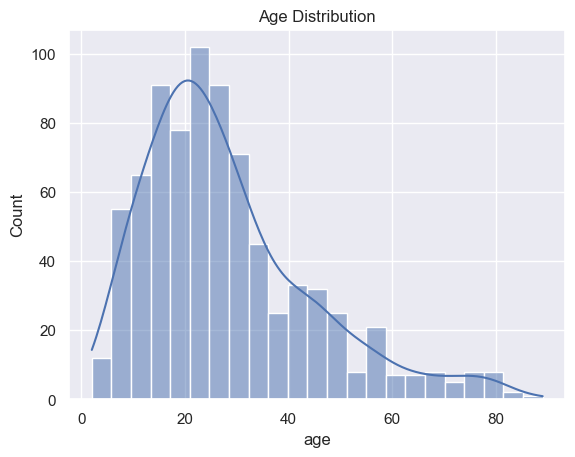

In [17]:
#histogram for age

sns.histplot(df['age'], kde = True)
plt.title("Age Distribution")
plt.show()

Box plot for indetifying outliers in the numerical columns

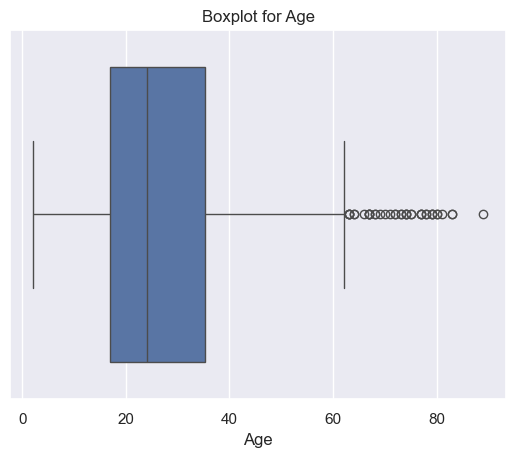

In [18]:
sns.boxplot(x = df['age'])
plt.title("Boxplot for Age")
plt.xlabel("Age")
plt.show()

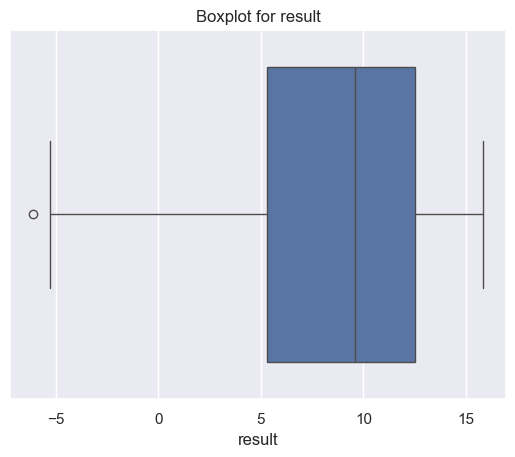

In [19]:
sns.boxplot(x = df['result'])
plt.title("Boxplot for result")
plt.xlabel("result")
plt.show()

In [20]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

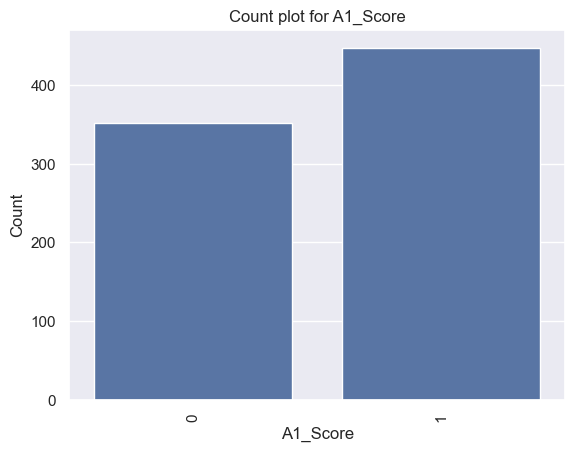

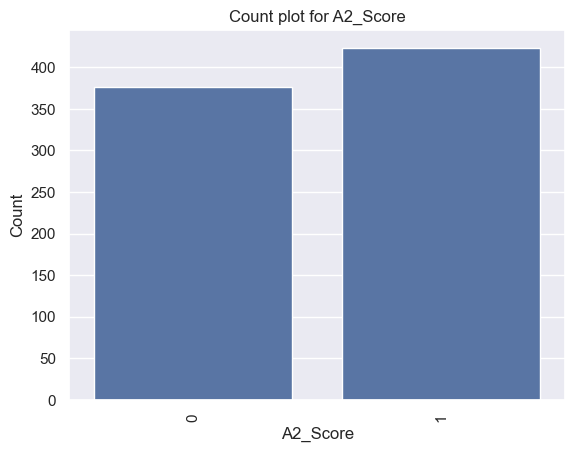

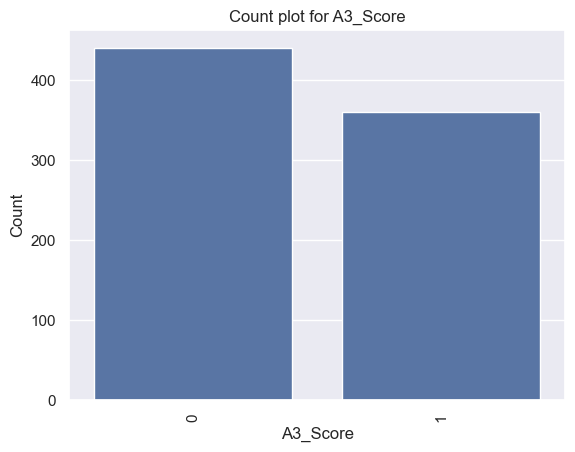

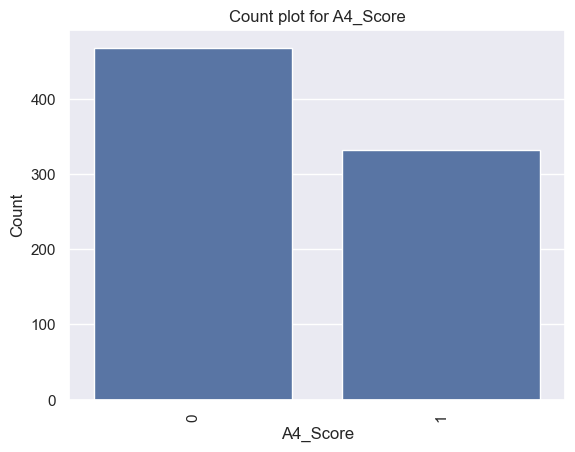

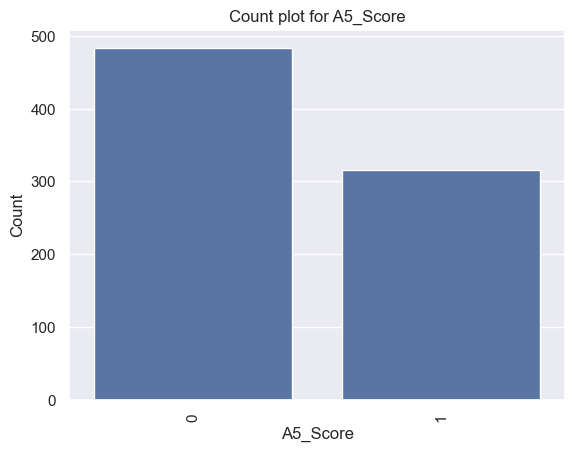

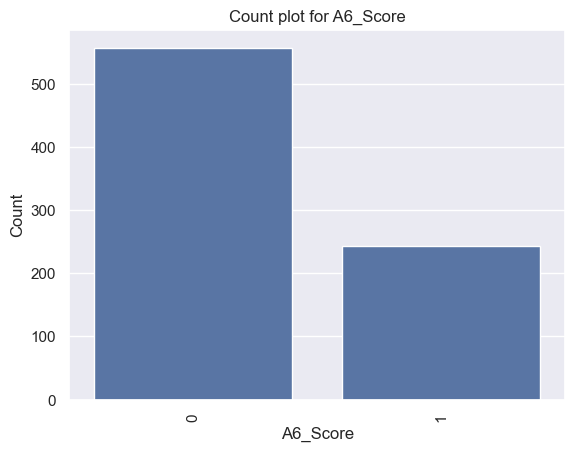

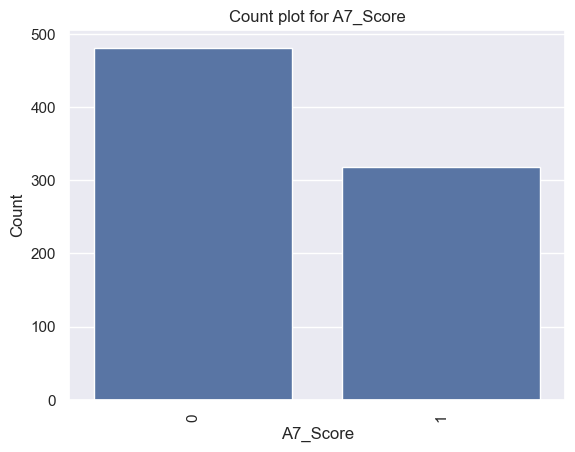

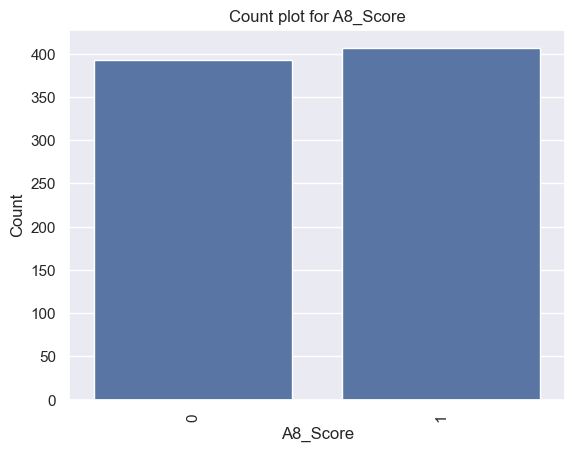

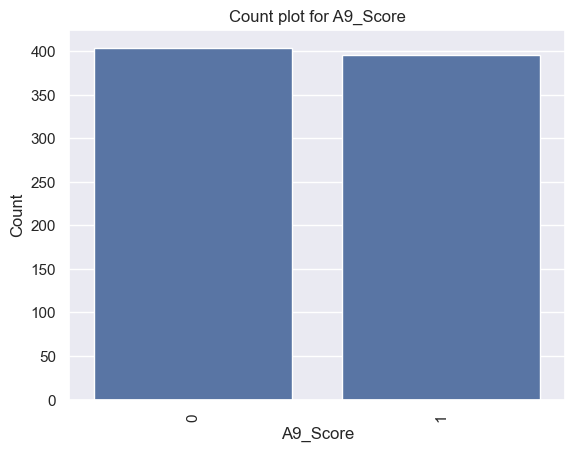

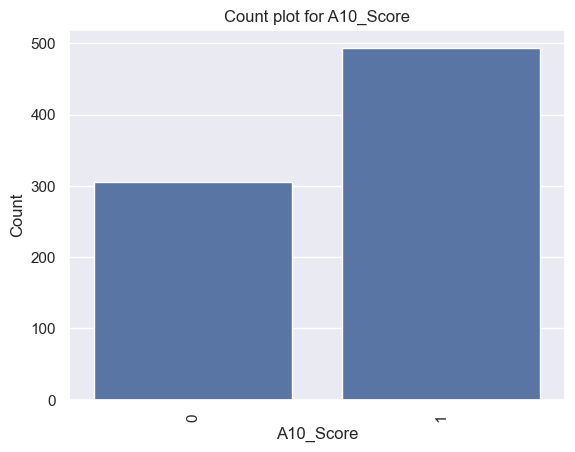

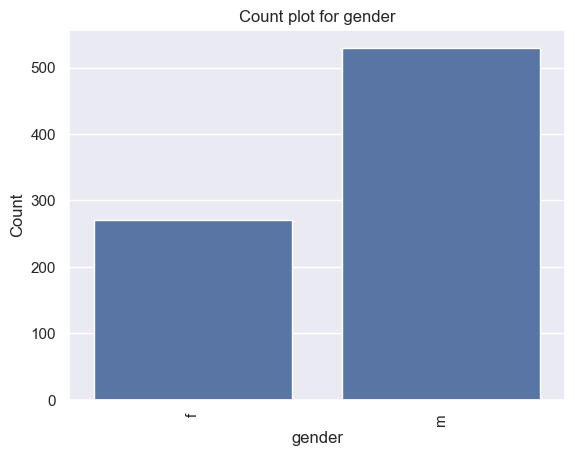

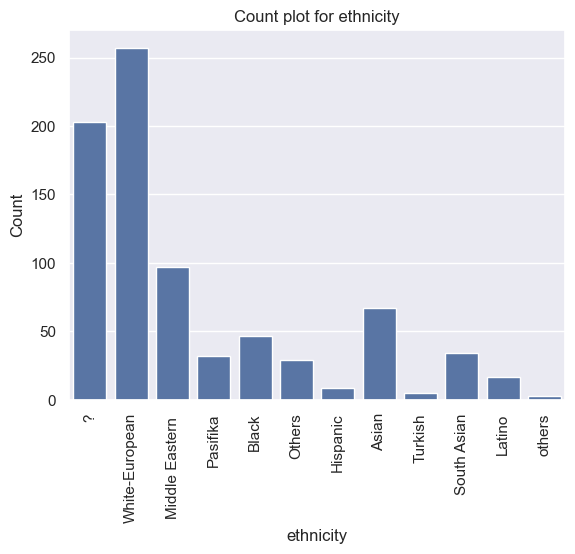

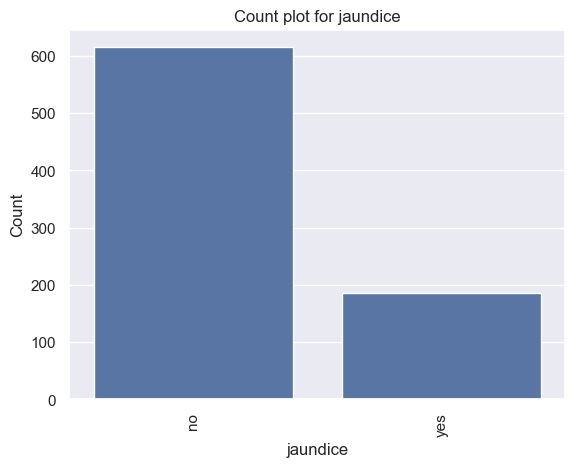

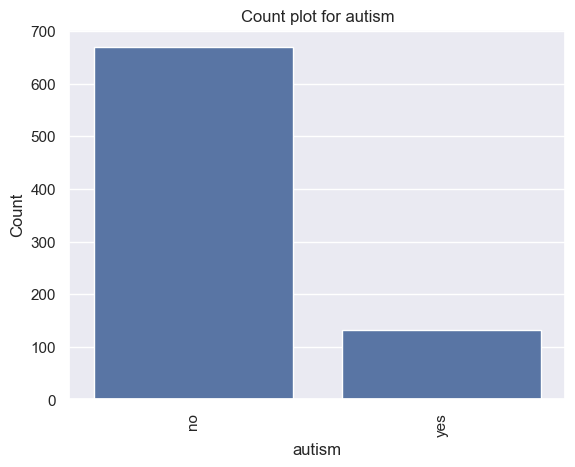

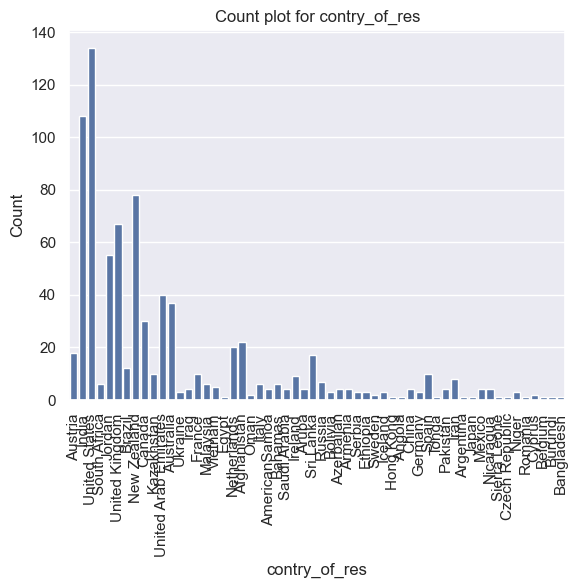

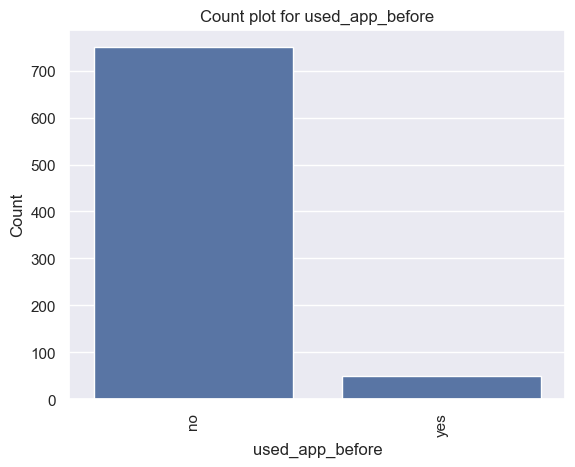

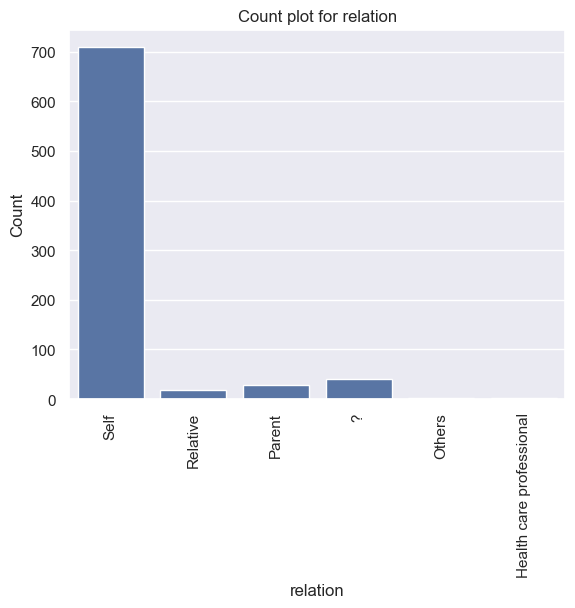

In [21]:
categorical_cols = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',  'gender',
       'ethnicity', 'jaundice', 'autism', 'contry_of_res', 'used_app_before',
        'relation']

for col in categorical_cols:
    sns.countplot(x = df[col])
    plt.title(f"Count plot for {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()


In [22]:
df['ethnicity'] = df['ethnicity'].replace({'?':'Others', 'others': 'Others'})

In [23]:
df['relation'].unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)

In [24]:
df['relation'] = df['relation'].replace(
    {
        '?':'Others',
        'Relative':'Others',
        'Parent':'Others',
        'Health care professional':'Others'
    }
)

In [25]:
obj_columns = df.select_dtypes(include = 'object').columns

In [26]:
print(obj_columns)

Index(['gender', 'ethnicity', 'jaundice', 'autism', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [27]:
#intialize a dictionary to store the encoders
encoders = {}

#apply label encoding and store the encoders
for col in obj_columns:
  label_encoder = LabelEncoder()
  df[col] = label_encoder.fit_transform(df[col])
  encoders[col] = label_encoder    # saving encoder col wise

  with open('enocoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

In [28]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,5,0,0,7,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47,1,5,0,0,25,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7,1,9,0,1,54,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23,0,5,0,0,54,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43,1,5,0,0,46,0,-4.777286,1,0


**Bivariate analysis**

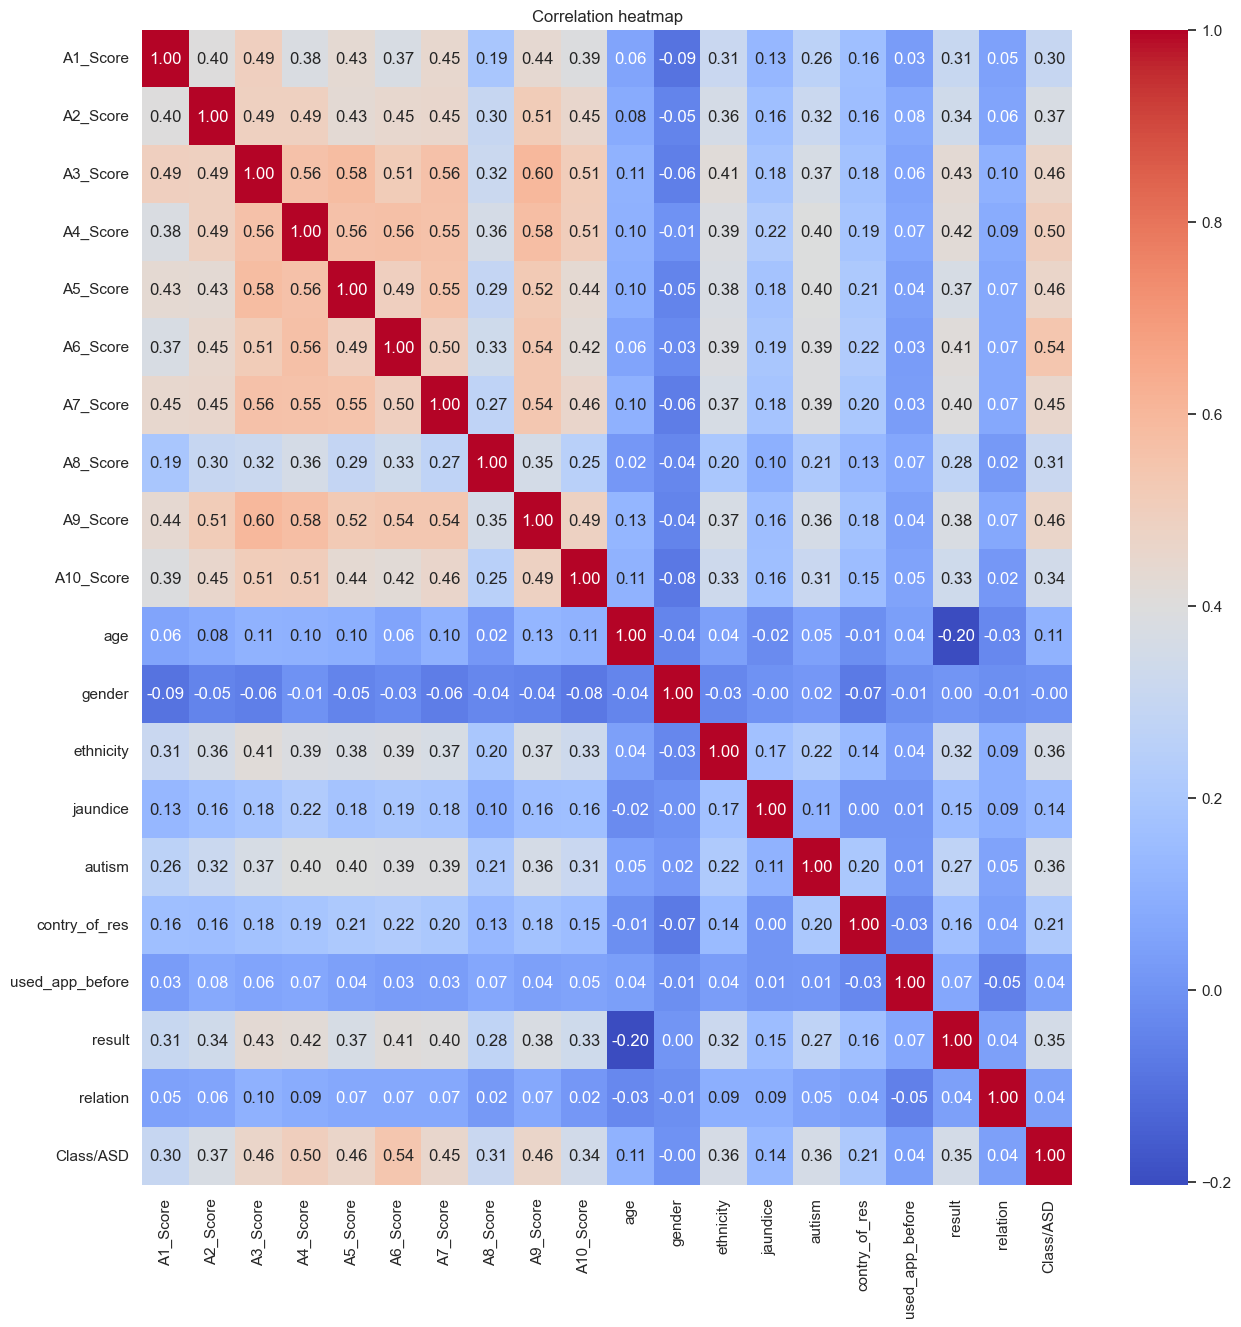

In [29]:
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation heatmap')
plt.show()

**Insights from EDA**

- there are few outliers in the numerical columns(age, result)
- there is a class imbalance in the target column
- there is a class imbalance in the categorical feature
- we dont have any highly correlated column
- performed label encoding and saved encoders

**Data Preprocessing**

In [30]:
#function to replace the outliers with median
def replace_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median = df[column].median()

    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median, df[column])

    return df

In [31]:
# replace outliers in the age column
df = replace_outliers(df, 'age')

train test split

In [32]:
x = df.drop('Class/ASD', axis = 1)
y = df['Class/ASD']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [34]:
# Get the feature columns from the training data
feature_columns = x_train.columns
# Save the feature names (order of columns) for future use
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)


In [35]:
print(y_train.shape)
print(y_test.shape)

(640,)
(160,)


In [36]:
print(y_train.value_counts())
print(y_test.value_counts())

Class/ASD
0    515
1    125
Name: count, dtype: int64
Class/ASD
0    124
1     36
Name: count, dtype: int64


In [37]:
smote = SMOTE(random_state = 42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [38]:
print(y_train_smote.value_counts())

Class/ASD
1    515
0    515
Name: count, dtype: int64


**Model Training**


In [39]:
#list of classifier
models = {
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(random_state = 42),
    "XGBoost": XGBClassifier(random_state = 42)
}

In [40]:
#dictionary to store the cross validation result
cv_scores = {}

#perform 5_fold cv for each model

for model_name, model in models.items():
  print(f"Training {model_name}...")
  cv_score = cross_val_score(model, x_train_smote, y_train_smote, cv = 5, scoring = "accuracy")
  cv_scores[model_name] = cv_score
  print(f"{model_name} cross validation accuracy: {np.mean(cv_score):.2f}")
  print("-"*50)

Training Decision Tree...
Decision Tree cross validation accuracy: 0.86
--------------------------------------------------
Training Random Forest...
Random Forest cross validation accuracy: 0.92
--------------------------------------------------
Training XGBoost...
XGBoost cross validation accuracy: 0.90
--------------------------------------------------


In [41]:
cv_scores

{'Decision Tree': array([0.80097087, 0.87864078, 0.88834951, 0.87864078, 0.84951456]),
 'Random Forest': array([0.90776699, 0.9368932 , 0.90776699, 0.9223301 , 0.90776699]),
 'XGBoost': array([0.85436893, 0.9223301 , 0.90776699, 0.90776699, 0.9223301 ])}

**Model selection and hyperparameter tuning**

In [42]:
#Intialize models
decision_tree = DecisionTreeClassifier(random_state = 42)
random_forest = RandomForestClassifier(random_state = 42)
xgboost_classifier = XGBClassifier(random_state = 42)


In [43]:
#Hyperparameter grids for RandomizedSearchCV
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20 , 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap':[True, False]

}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

In [44]:
#hyperparameter tuning for 3 tree based models

#below steps can be automated by using a for loop or by using  a pipeline

#perform RandomizedSearchCV for each model
random_search_dt = RandomizedSearchCV(estimator = decision_tree, param_distributions = param_grid_decision_tree, n_iter = 20, cv = 5, scoring = 'f1', random_state = 42)
random_search_rf = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid_rf, n_iter = 20, cv = 5, scoring = 'f1', random_state = 42)
random_search_xgb = RandomizedSearchCV(estimator = xgboost_classifier, param_distributions = param_grid_xgb, n_iter = 20, cv = 5, scoring = 'f1', random_state = 42)


In [45]:
#fit the models
random_search_dt.fit(x_train_smote, y_train_smote)
random_search_rf.fit(x_train_smote, y_train_smote)
random_search_xgb.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='f1')

In [46]:
best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_score = random_search_dt.best_score_
  best_model = random_search_dt.best_estimator_

if random_search_rf.best_score_ > best_score:
  best_score = random_search_rf.best_score_
  best_model = random_search_rf.best_estimator_

if random_search_xgb.best_score_ > best_score:
  best_score = random_search_xgb.best_score_
  best_model = random_search_xgb.best_estimator_


In [47]:
print(f"Best Model: {best_model}")
print(f"Best Score: {best_score: .2f}")

Best Model: RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=50, random_state=42)
Best Score:  0.93


In [48]:
#save the best model

with open('best_model.pkl', 'wb') as f:
  pickle.dump(best_model, f)

**Evaluation**

In [49]:
#evaluate on test data
y_test_pred = best_model.predict(x_test)
print(f"Accuracy on test data:\n {accuracy_score(y_test, y_test_pred)}")
print(f"Confusion matrix on test data:\n {confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report on test data:\n {classification_report(y_test, y_test_pred)}")


Accuracy on test data:
 0.83125
Confusion matrix on test data:
 [[108  16]
 [ 11  25]]
Classification report on test data:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       124
           1       0.61      0.69      0.65        36

    accuracy                           0.83       160
   macro avg       0.76      0.78      0.77       160
weighted avg       0.84      0.83      0.83       160

